# Importing Libraries

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from PIL import Image
import string
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
import time
from sklearn.utils import shuffle
import imageio

In [0]:
!apt-get -qq install -y libsm6 libxext6

In [0]:
# running this cell once, produces error at first, so rerun the cell
!pip install -q -U opencv-python 

In [0]:
!unzip /content/data.zip

# Functions Definitions

In [0]:
def get_k_acc_PyTorch(K,x_train,y_OH_train,x_test,y_OH_test):
  for k in K:
    accuracy_train = fn.accuracy_n(fn.forward(x_train),y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

    x_test =x_test.to(device)
    y_OH_test=y_OH_test.to(device)

    accuracy_test = fn.accuracy_n(fn.forward(X_test),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')

def accuracy_n(y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

# FFNN
def run_FFNN(X_train_scaled,X_test_scaled,Y_OH_train,Y_OH_test,class_name="FFNNetwork_Regularized",Epochs=6000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch'):
  if(class_name == "FFNNetwork_Regularized"):
    fn = FFNNetwork_Regularized()
  elif(class_name == "FFNNetwork"):
    fn = FFNNetwork()
  loss_fn = fn.cross_entropy
  opt = optim.SGD(fn.parameters(), lr=0.9)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  X_train_scaled = X_train_scaled.to(device)
  Y_OH_train = Y_OH_train.to(device)
  fn.to(device)

  tic = time.time()
  fit(X_train_scaled, Y_OH_train, fn, opt, loss_fn, epochs=Epochs)
  toc = time.time()

  print("Time for training model: {}s".format(np.round(toc-tic,3)))

  X_test_scaled =X_test_scaled.to(device)
  Y_OH_test=Y_OH_test.to(device)

  accuracy_train = fn.accuracy(fn.forward(X_train_scaled),Y_OH_train)
  print('Training Accuracy: {}'.format(accuracy_train))


  accuracy_test = fn.accuracy(fn.forward(X_test_scaled),Y_OH_test)
  print('Testing Accuracy: {}'.format(accuracy_test))
  print('\n')
  
  cm = confusion_matrix(torch.argmax(Y_OH_test,dim=1).to("cpu").numpy(), torch.argmax(fn.forward(X_test_scaled), dim=1).to("cpu").to("cpu").detach().numpy())
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'_Confusion_matrix.png')
  else:
    plt.show()    

  return fn.forward(X_test_scaled), accuracy_test, fn

def fit(x, y, model, opt, loss_fn, epochs = 1000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch_loss'):
  
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    x, y = shuffle(x, y, random_state=0)
    y_hat = model.forward(x)
    loss = loss_fn(y_hat, y)
    loss_arr.append(loss.item())
    acc_arr.append(model.accuracy(y_hat,y))
    loss.backward()
    opt.step()
    opt.zero_grad()

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  if(save_fig):
    plt.savefig(save_dir+save_name+'_loss.png')
  else:
    plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

# kNN    
def euclideanDistance(x,y):
  distance = 0
  for i in range(x.size):
    distance += (x[i] - y[i])**2
  return np.sqrt(distance)

def first_comes_first(arr,x):
    arr[1:] = arr[0:-1]
    arr[0] = x
    return arr

def kNN(test_data,train_data,train_class,k):
  test_pred = np.zeros(test_data.shape[0])
  for i in range(test_data.shape[0]):
    dist_arr = np.asarray(np.zeros(k))
    nearest = np.asarray(np.zeros(k))
    ret_arr = np.array([])
    for j in range(k):
      dist_arr[j] = euclideanDistance(train_data[j],test_data[i])
      nearest[j]=j

    for j in range(train_data.shape[0]):
      temp_dist = euclideanDistance(test_data[i],train_data[j])
      if(temp_dist <= np.amin(dist_arr)):
        dist_arr = first_comes_first(dist_arr,temp_dist)
        nearest = first_comes_first(nearest,j)

    for j in (nearest):
      ret_arr = np.append(ret_arr,train_class[int(j)])
    ret_arr = np.array([int(q) for q in ret_arr])
    test_pred[i] = np.argmax(np.bincount(ret_arr))

  return test_pred

def getAccuracy(testSet, predictions):
  correct = 0
  testSet = np.array(testSet)
  for x in range(testSet.shape[0]):
    if (testSet[x] == predictions[x]):
      correct += 1
  return (correct/float(testSet.shape[0])) * 100.0

def run_kNN(X_train,X_test,Y_OH_train,Y_OH_test,k=[1,2,3,4,5],save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_kNN'):
  #scaler = StandardScaler()
  #X_train_scaled = scaler.fit_transform(X_train)
  #X_test_scaled = scaler.transform(X_test)
  acc_arr = np.zeros(len(k))
  Y_pred = np.array([])
  max_acc = 0
  for i in range(len(k)):
    if(k[i] == 0):
      continue
    else:
      test_pred = kNN(X_test, X_train, Y_train, k[i])
      acc_arr[i] = (getAccuracy(test_pred, Y_test))
      print(k[i], acc_arr[i])
  acc_arr = np.array(acc_arr)
  Y_pred = kNN(X_test, X_train, Y_train, k[np.argmax(acc_arr)])
  print("Maximum accuracy obtained for k={} : {}".format(k[np.argmax(acc_arr)],np.amax(acc_arr)))

  cm = confusion_matrix(np.argmax(Y_OH_test,axis=1), Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()

  return Y_pred, np.amax(acc_arr)  
# SVM
def run_SVM(X_train_scaled,X_test_scaled,Y_train,Y_test, print_details = False,cv = 5,save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_SVM'):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  params_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 0.005, 1e-4],
                      'C': [1, 10, 100, 500, 600,  725, 750, 775, 800, 900, 1000]},
                      {'kernel': ['linear'], 'C': [1, 10, 50, 100, 200, 500, 750, 1000]}]

  svm_model = GridSearchCV(SVC(), params_grid, cv=cv)
  svm_model.fit(X_train_scaled, Y_train)
  final_model = svm_model.best_estimator_
  Y_pred = final_model.predict(X_test_scaled)
  
  print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
  print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

  if(print_details):
    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
    print(confusion_matrix(Y_test,Y_pred))
    print("\n")
    print(classification_report(Y_test,Y_pred))
    svm_model.score

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
   plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()
  return Y_pred, final_model.score(X_test_scaled  , Y_test )*100  

def plot_portraits(images, h, w, n_row, n_col,save_fig=False,save_dir='Output-images/',save_name='Eigen_faces'):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    if(save_fig):
      plt.savefig(save_dir+save_name+'.png')

def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    print(U[:,:n_pc].shape, S[:n_pc].shape, V[:n_pc].shape)
    print(U.shape, S.shape, V.shape)
    return projected, components, mean, centered_data

def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image

def generate_distorted_image(temp,h,w,j):
  gray_new_img = cv2.equalizeHist(temp)  
  gray_new_img = Image.fromarray(gray_new_img)
  gray_new_img = np.array(gray_new_img.rotate(np.random.randn()*((-1)**j)*5))

  for l in range(gray_new_img.shape[0]):
    if(gray_new_img[l][0] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][ctr],0)):
        ctr += 1
      gray_new_img[l][0:ctr] = np.ones(gray_new_img[l][0:ctr].size)*gray_new_img[l][ctr]
    if(gray_new_img[l][-1] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][-1-ctr],0)):
        ctr += 1
      gray_new_img[l][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[l][gray_new_img.shape[1]-ctr:].size)*gray_new_img[l][-1-ctr]  
  
  gray_new_img = Image.fromarray((gray_new_img*(1+noise_level*((-1)**j)*np.random.randn(w,h))).astype(np.uint8) )  
  gray_new_img = gray_new_img.crop((np.random.randint(10), np.random.randint(10), h-np.random.randint(10), w-np.random.randint(10))) 
  gray_new_img = gray_new_img.resize((w,h))
  gray_new_img = cv2.equalizeHist(np.array(gray_new_img).astype(np.uint8))
  return gray_new_img

def quadrant_checker(y):
  if(y<64 and y>0):
    return True
  else:
    return False
    
def get_aligned_img(img, sF=1.05, mN=1): # input PIL Image
  img = np.array(img)
  img_raw = img.copy() 
  eyes = eye_cascade.detectMultiScale(img,sF,mN)
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  eye_1 = (0,0,0,0)
  eye_2 = (0,0,0,0)
  eyes = np.array(eyes)
  possible_eyes = []
  for i in range(len(eyes)):
    if(quadrant_checker(eyes[i][1])):
      possible_eyes.append(i)
  eyes = eyes[possible_eyes]
  if(len(eyes) == 0):
    return cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)

  left_eye = eyes[np.argmin(eyes.T[0])]
  right_eye = eyes[np.argmax(eyes.T[0])]
  cv2.rectangle(img,(left_eye[0], left_eye[1]),(left_eye[0]+left_eye[2], left_eye[1]+left_eye[3]), 1)
  cv2.rectangle(img,(right_eye[0], right_eye[1]),(right_eye[0]+right_eye[2], right_eye[1]+right_eye[3]), 1)
  left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
  left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]

  right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
  right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]

  if(len(left_eye) == 0 or len(right_eye) == 0):
    return cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)

  cv2.circle(img, left_eye_center, 1, (255, 0, 0) , 1)
  cv2.circle(img, right_eye_center, 1, (255, 0, 0) , 1)
  cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
  if(left_eye_y > right_eye_y):
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock

  else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock

  cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
  cv2.line(img,left_eye_center, point_3rd,(67,67,67),1)
  cv2.line(img,right_eye_center, point_3rd,(67,67,67),1)
  
  a = euclidean_distance(left_eye_center, point_3rd)
  b = euclidean_distance(right_eye_center, left_eye_center)
  c = euclidean_distance(right_eye_center, point_3rd)

  if(b == 0 or c == 0):
    #new_img = Image.fromarray(img_raw)
    gray_new_img = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    #return gray_new_img

  else:
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    angle = np.arccos(cos_a)
    angle = (angle * 180) / math.pi

    if direction == -1:
      angle = 90 - angle  

    new_img = Image.fromarray(img_raw)
    new_img = np.array(new_img.rotate(direction * angle))
    gray_new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)

    for i in range(gray_new_img.shape[0]):
      if(gray_new_img[i][0] == 0):
        ctr = 0
        while(np.allclose(gray_new_img[i][ctr],0)):
          ctr += 1
        gray_new_img[i][0:ctr] = np.ones(gray_new_img[i][0:ctr].size)*gray_new_img[i][ctr]
      if(gray_new_img[i][-1] == 0):
        ctr = 0
        while(np.allclose(gray_new_img[i][-1-ctr],0)):
          ctr += 1
        gray_new_img[i][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[i][gray_new_img.shape[1]-ctr:].size)*gray_new_img[i][-1-ctr]

  return gray_new_img

def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

def hist_equalizer(im):
  img_yuv = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2YUV)
  # equalize the histogram of the Y channel
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
  # convert the YUV image back to RGB format
  im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
  return im

def get_cropped_faces(cascade, eye_cascade, test_image, w=128, h=128, scaleFactor = 1.1, minNeighbors=1, sF = 1.05, mN = 1):
  test_images = np.zeros(h*w)

    # Converting to grayscale as opencv expects detector takes in input gray scale images
    #gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    #faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
  faces_rect = cascade.detectMultiScale(test_image, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

  for (x, y, _w, _h) in faces_rect:
    crop_im = im[y:y+_h, x:x+_w]
    crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
    crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
    crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
    crop_im = hist_equalizer(crop_im)
    crop_im = get_aligned_img(crop_im,sF,mN)
#      crop_im = cv2.cvtColor(crop_im, cv2.COLOR_RGB2GRAY)
    temp = np.array(crop_im)
    
    test_images = np.row_stack((test_images,temp.ravel()))
  
  return test_images[1:]

# Loading Data 

In [0]:
path = "/content"
train_folder = "/train"
val_folder = "/validation"
sub_folder = np.array(["/un-masked","/masked"])
test_folder = "/test"
cascade_folder = "/cascade_classifiers"
haar_cascade_face = cv2.CascadeClassifier(path+cascade_folder+'/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier(path+cascade_folder+'/haarcascade_eye.xml')

## For visualization only

Faces found:  2


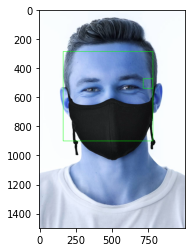

In [0]:
# Loading the image to be tested
test_image = np.array(cv2.imread(path+val_folder+'/masked/28.jpg'))

faces_rects = haar_cascade_face.detectMultiScale(test_image, scaleFactor = 1.05, minNeighbors = 1)
# Let us print the no. of faces found
#convert image to RGB and show image
print('Faces found: ', len(faces_rects))

for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(test_image)

In [12]:
im = np.array(cv2.imread(path+train_folder+'/un-masked/14.jpg'))
faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.01, minNeighbors=1)    
print(faces_rect)
temp = np.array([])
for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
  crop_im = im[y:y+_h, x:x+_w]
  crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  crop_im = get_aligned_img(crop_im,1.05,1)
  temp = np.array(crop_im)        
  temp = cv2.equalizeHist(temp).ravel()
plt.imshow(temp.reshape((w,h)),cmap='gray')

TypeError: ignored

## loading data

In [0]:
%%time 
noise_level = 0.1
h = 128 
w = 128 
redundency_per_image = 3
train_images = np.array([])
Y_train = np.array([])
for i in range(sub_folder.size):
  for img in os.listdir(path+train_folder+sub_folder[i]):
    if(img == ".ipynb_checkpoints"):
      continue
    else:
      im = cv2.imread(path+train_folder+sub_folder[i]+'/'+img)
      faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.01, minNeighbors=1)    
      for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
        crop_im = im[y:y+_h, x:x+_w]
        crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
        crop_im = get_aligned_img(crop_im,1.05,1)
        temp = np.array(crop_im)        
        if(train_images.size == 0):
          train_images = cv2.equalizeHist(temp).ravel()
          Y_train = np.append(Y_train,i)
        else:
          train_images = np.row_stack((train_images,cv2.equalizeHist(temp).ravel()))
          Y_train = np.append(Y_train,i)
        for j in range(2):
          for k in range(redundency_per_image):
            train_images = np.row_stack((train_images, generate_distorted_image(temp,h,w,j).ravel() ))
            Y_train = np.append(Y_train,i)
mean_face = np.mean(train_images,axis=0)
plt.imshow(mean_face.reshape((h, w)), cmap=plt.cm.gray)
plt.colorbar()
plt.savefig('Output-images/mean_face.png')

In [0]:
Y_val = np.array([])
val_images = np.array([])
for i in range(sub_folder.size):
  for img in os.listdir(path+val_folder+sub_folder[i]):
    if(img == ".ipynb_checkpoints"):
      continue
    else:
      im = cv2.imread(path+val_folder+sub_folder[i]+'/'+img)
      faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.01, minNeighbors=1)
      for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
        crop_im = im[y:y+_h, x:x+_w]
        crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
        crop_im = get_aligned_img(crop_im,1.05,1)
        temp = np.array(crop_im)        
        if(val_images.size == 0):
          val_images = cv2.equalizeHist(temp).ravel()
          Y_val = np.append(Y_val,i)
        else:
          val_images = np.row_stack((val_images,cv2.equalizeHist(temp).ravel()))
          Y_val = np.append(Y_val,i)

## considering only the a portion of the face

In [0]:
train_imgs = train_images[:,(w*h)//2:]
val_imgs = val_images[:,(w*h)//2:]

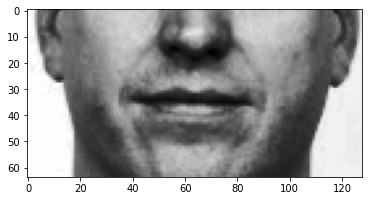

In [112]:
plt.imshow(train_imgs[0].reshape((w)//2,h),cmap='gray')

# PCA

In [0]:
n_components = train_imgs.shape[0]//7 # next 18

In [124]:
%%time
X_train, C, M, Y = pca(train_imgs, n_pc=n_components) # C -> (12,1444) X_train -> (48,12) M -> (1,1444) Y -> (48,1444)
eigenfaces = C.reshape((n_components, (h)//2, w)) # eigenfaces -> (50, 64, 64)
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()

(350, 50) (50,) (50, 8192)
(350, 350) (350,) (8192, 8192)
CPU times: user 41.3 s, sys: 974 ms, total: 42.3 s
Wall time: 22.5 s


In [0]:
X_val = np.matmul(val_imgs-M,C.T)
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()

In [0]:
np.savetxt("/content/Output-images/M_mask.txt",M)
np.savetxt("/content/Output-images/C_mask.txt",C)

Eigen Faces (Number of components = 50)


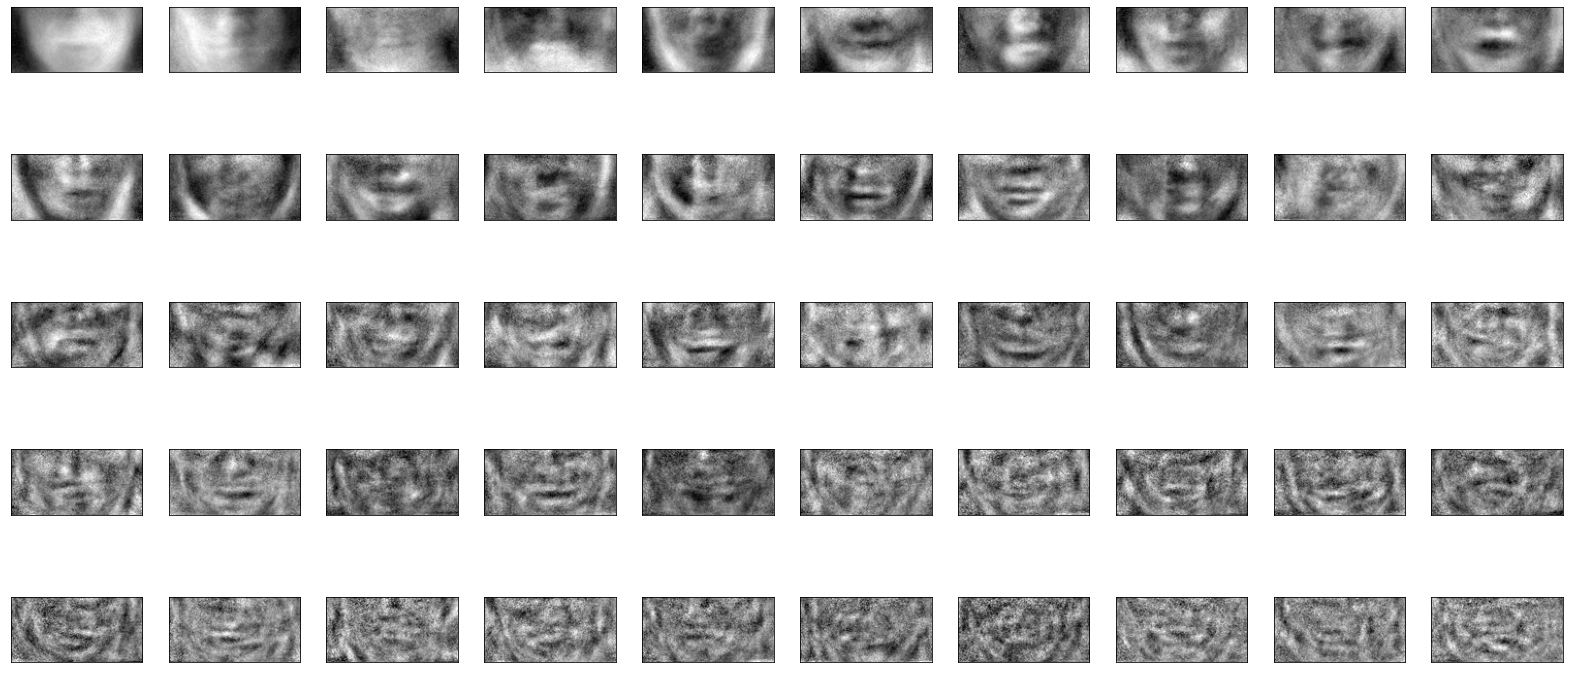

In [126]:
print("Eigen Faces (Number of components = {})".format(n_components))
plot_portraits(eigenfaces, (h)//2, w, 5, 10,save_fig=True,save_dir='Output-images/',save_name='Eigen_faces_50')

# Classifier Training

In [127]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled, Y_OH_train, Y_train, X_val_scaled, Y_OH_val, Y_val = map(torch.tensor, (X_train_scaled, Y_OH_train, Y_train, X_val_scaled, Y_OH_val, Y_val))
X_train_scaled = X_train_scaled.float()
Y_train = Y_train.long()

X_val_scaled = X_val_scaled.float()
Y_val = Y_val.long()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [0]:
# simply define a silu function
def hakuna_matata(x,x0 = 0,a=1):
  return 2/(1+torch.exp(-a*(x-x0))) - 1 # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class Hakuna_Matata(nn.Module):
  def __init__(self,x0=0,a=1):
    super().__init__() # init the base class
    self.a = a
    self.x0 = x0

  def forward(self, ip):
    return hakuna_matata(ip,self.x0,self.a) # simply apply already implemented SiLU

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.7141292424041505
Loss after training 0.1276732612286054
Time for training model: 5.324s
Training Accuracy: 1.0
Testing Accuracy: 0.800000011920929




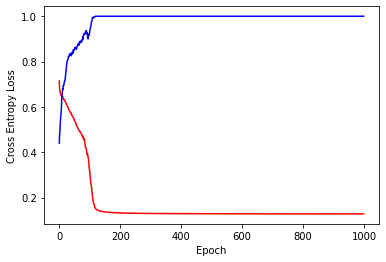

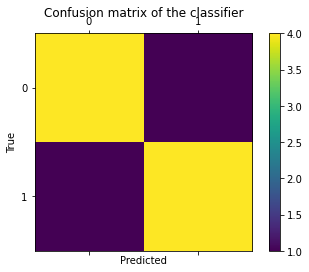

In [172]:
class RegularizedLinear(nn.Linear):
    def __init__(self, *args, ar_weight=1e-3, l1_weight=1e-3, l2_weight=2, **kwargs):
        super(RegularizedLinear, self).__init__(*args, **kwargs)
        #self.ar_weight = ar_weight
        #self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self._losses = {}

    def forward(self, input):
        output = super(RegularizedLinear, self).forward(input)
        #self._losses['activity_regularization'] = (output * output).sum() * self.ar_weight
        #self._losses['l1_weight_regularization'] = torch.abs(self.weight).sum() * self.l1_weight
        self._losses['l2_weight_regularization'] = torch.abs(torch.mul(self.weight,self.weight)).sum() * self.l2_weight
        return output

class FFNNetwork_Regularized(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        RegularizedLinear(n_components,45), 
        nn.BatchNorm1d(45),
        Hakuna_Matata(-3.0,-1.5),
        RegularizedLinear(45,16), 
        nn.BatchNorm1d(16),
        Hakuna_Matata(-3.0,-1.5),
        RegularizedLinear(16,2), 
        nn.BatchNorm1d(2),
        Hakuna_Matata(-3.0,-1.5),
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def softmax(self,x):
    return torch.exp(x)/torch.sum(torch.exp(x))

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == torch.argmax(y, dim=1)).float().mean()

  def predict(self, X):
    Y_pred = self.forward(x)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train_scaled,X_val_scaled,Y_OH_train,Y_OH_val,Epochs=1000,save_fig=True)

# Testing

In [201]:
# inputs -> model, test images directory, w, h, scaleFactor, minNeighbors, classes, save_dir
classes = np.array(["Un-Masked", "Masked"])
model.eval()
for img in os.listdir(path+test_folder):
  if(img == ".ipynb_checkpoints"):
    continue
  else:
    tic = time.time()
    im = cv2.imread(path+test_folder+'/'+img)
    faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.05, minNeighbors=1)
    for (x, y, _w, _h) in faces_rect:
      crop_im = im[y:y+_h, x:x+_w]
      crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
      crop_im = hist_equalizer(crop_im)
      crop_im = get_aligned_img(crop_im,1.05,1)
      temp = np.array(crop_im[:,(w)//2:]).ravel()
      X_test = np.matmul(temp-M,C.T)    
      X_test_scaled = scaler.transform(X_test.reshape(1,-1))
      X_test_scaled = torch.tensor(X_test_scaled).float()
      t = X_test_scaled[0].reshape(1,-1).to('cuda')
      with torch.no_grad():
        p = model.forward(t).to("cpu").detach()
      Y_pred_FFNN = torch.argmax(p,dim=1)
      if(Y_pred_FFNN == 0):
        cv2.rectangle(im, (x, y), (x+_w, y+_h), (255, 0, 0), 2)
        cv2.putText(im, classes[0], (x + 6, y+_h - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
      elif(Y_pred_FFNN == 1):
        cv2.rectangle(im, (x, y), (x+_w, y+_h), (0, 255, 0), 2)
        cv2.putText(im, classes[1], (x + 6, y+_h - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    
    imageio.imwrite('/content/Output-images/'+img, im)
    print(time.time()-tic)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax

1.8575048446655273


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax

0.6259257793426514
0.1488032341003418


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax

1.5814077854156494
0.15084147453308105


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [0]:
model.forward(X_val[-1])

tensor([[0.8419, 0.1581]])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(-0.5, 639.5, 768.5, -0.5)

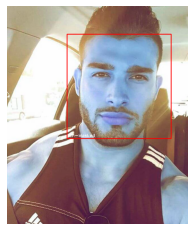

In [200]:
model.eval()
im = cv2.imread(path+val_folder+sub_folder[0]+'/29.jpg')
#im = cv2.imread(path+'/w_mask.jpeg')
faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.05, minNeighbors=1)
for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
  crop_im = im[y:y+_h, x:x+_w]
  crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  crop_im = get_aligned_img(crop_im,1.05,1)
  temp = np.array(crop_im).ravel()[(w*h)//2:]      
  X_test = np.matmul(temp-M,C.T)    
  X_test_scaled = scaler.transform(X_test.reshape(1,-1))
  X_test_scaled = torch.tensor(X_test_scaled).float()
  X_test_scaled = X_test_scaled[0].reshape(1,-1).to('cuda')
  t = X_test_scaled[0].reshape(1,-1).to('cuda')
  with torch.no_grad():
    p = model.forward(t).to("cpu").detach()
  print(p)
  Y_pred_FFNN = torch.argmax(p,dim=1)
  if(Y_pred_FFNN == 0):
    cv2.rectangle(im, (x, y), (x+_w, y+_h), (255, 0, 0), 2)
    cv2.putText(im, classes[0], (x + 6, y+_h - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
  elif(Y_pred_FFNN == 1):
    cv2.rectangle(im, (x, y), (x+_w, y+_h), (0, 255, 0), 2)
    cv2.putText(im, classes[1], (x + 6, y+_h - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
plt.imshow(im)  
plt.axis('off')